In [153]:
import pandas as pd
import matplotlib.pyplot as plt

class IOT_Device():
    
    def __init__(self, name, data_class, data_base):
        self.data_base = data_base
        self.data_base.columns = [name]
        self.data_class = data_class
        
class Temperature_Sensor(IOT_Device):
    
    def __init__(self, name, data_base, data_class = 'temperature'):
        super().__init__(name, data_class, data_base)
    
        
#DMAG stands for Data Mega Aggregator        
class DMAG():
    
    def __init__(self):
        #{data_class: df}
        self.dict_of_data_classes = {}
        
    def input_IOT_Device(self, IOT_Device):
        
        data_class = IOT_Device.data_class
        df = IOT_Device.data_base
        print('Inputting IOT Device...')
        
        if len(self.dict_of_data_classes):
            
            print('One or more data classes have been stored...')
            if data_class in self.dict_of_data_classes.keys():
                print('Existing data found for data class. Now merging new data...')
                self.dict_of_data_classes[data_class] = pd.merge(self.dict_of_data_classes[data_class], df, how='outer', left_index=True, right_index=True)
                return self

            else:
                print('No existing data found for data class. Creating new data class in DMAG...')
                self.dict_of_data_classes[data_class] = df
                return self
        else:
            print('No existing data found for data class. Creating new data class in DMAG...')
            self.dict_of_data_classes[data_class] = df
            return self
            
    def extract_data_class(self, data_class):
        print('Extracting ' + data_class + '...')
        return self.dict_of_data_classes[data_class]
    
class Model():
    
    def __init__(self, name, DMAG, data_class_list):
        self.name = name
        self.data_base = {}
        for data_class in data_class_list:
            assert data_class in DMAG.dict_of_data_classes
            self.data_base[data_class] = DMAG.dict_of_data_classes[data_class]

class RCFModel(Model):
    
    def __init__(self, DMAG, name = 'RCF', data_class_list = ['temperature']):
        super().__init__(name, DMAG, data_class_list)
        
    def signal_fire(self, check_location, return_type = 'df'):
        
        #Using rubbish chute temperature
        df = self.data_base['temperature']
        
        locations = list(df.columns)
        
        for location in locations:
            
            if location == check_location:
            
                temp_df = pd.DataFrame(df[location])
                temp_df['rolling 1-day mean'] = temp_df[location].rolling(1440).mean()
                temp_df['rolling 1-day sigma'] = temp_df[location].rolling(1440).std()
                temp_df['threshold'] = temp_df['rolling 1-day mean'] + temp_df['rolling 1-day sigma']*2

                temp_df['Fire Detected'] = np.where(temp_df[location] > temp_df['threshold'], 1, 0)

                #Measure 1 includes auto-deploying chute sprinklers and informs Town Council cleaners to be on scene to cordon off area
                #This is deployed immediately after the temperature exceeds 1 sigma above the mean
                temp_df['Fire Measure 1'] = np.where((temp_df['Fire Detected'].shift(5) == 1) & (temp_df['Fire Detected'] == 1), 1, 0)
                temp_df['Fire Measure 2'] = np.where((temp_df['Fire Detected'].shift(29) == 1) & (temp_df['Fire Measure 1'] == 1), 2, 0)
                
                final_conditions = [
                    (temp_df['Fire Measure 2'] == 2),
                    (temp_df['Fire Measure 1'] == 1) & (temp_df['Fire Measure 2'] != 2),
                    (temp_df['Fire Detected'] == 0)
                ]
                
                final_actions = ['Fire Measure 2', 'Fire Measure 1', 'No Action Required']
                
                temp_df['Final Measure'] = np.select(final_conditions, final_actions)
                
                if return_type == 'df':
                    return temp_df
                
                elif return_type == 'messages':
                    
                    final_list = list(temp_df['Final Measure'])
                    index_list = list(temp_df.index)
                    for i in range(len(index_list)):
                        if final_list[i] == 'Fire Measure 1' or final_list[i] == 'Fire Measure 2':
                            print (str(index_list[i]) + ':' + final_list[i])
                            
                elif return_type == 'chart':
                    
                    fig = plt.figure(figsize = [15, 9] )
                    gs = fig.add_gridspec(4, 2)
                    main_fig = fig.add_subplot(gs[:3,:])
                    main_fig.plot( temp_df[location], label = location + ' temperature', color = 'blue')
                    main_fig.plot( temp_df['threshold'], label = 'Temperature threshold', color = 'green')
                    main_fig.yaxis.tick_right()
                    main_fig.yaxis.set_label_position("right")
                    main_fig.legend(loc = 'best')
                    
                    action_fig = fig.add_subplot(gs[3,:])
                    action_fig.plot(temp_df['Fire Measure 1'], label = 'Fire Measure 1', color = 'red')
                    action_fig.plot(temp_df['Fire Measure 2'], label = 'Fire Measure 2', color = 'black')

In [154]:

periods = 7 * 24 * 60
tidx = pd.date_range('2020-06-06', periods=periods, freq='T')
import random
i = 0
temp_data = []
while i < 10080:
    if i in range(2500,2525):
        temp = round(random.uniform(250,300),1)
        temp_data.append(temp)
    elif i in range(5000,6000):
        temp = round(random.uniform(250,300),1)
        temp_data.append(temp) 
    elif i in range(8010,9000):
        temp = round(random.uniform(250,300),1)
        temp_data.append(temp) 
    else:
        temp = round(random.uniform(30, 35), 1)
        temp_data.append(temp)

    i += 1

df = pd.DataFrame(temp_data)
df.index = tidx
df.columns = ['temp.']

punggol_rb_a = Temperature_Sensor('Punggol Blk 71 Chute A',df)


Inputting IOT Device...
No existing data found for data class. Creating new data class in DMAG...


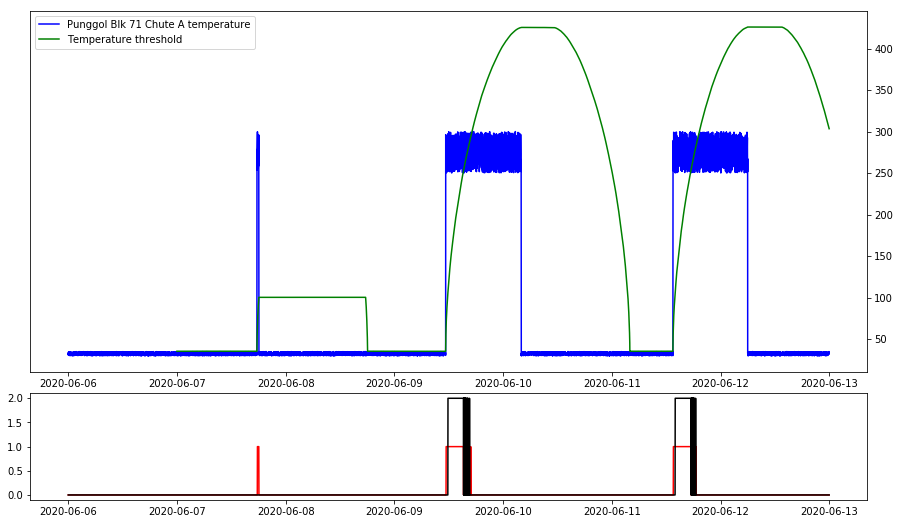

In [155]:
dmag = DMAG()
dmag.input_IOT_Device(punggol_rb_a)

RCFModel(dmag).signal_fire('Punggol Blk 71 Chute A', 'chart')

In [78]:
import random
i = 0
temp_data = []
while i < 10080:
    if i in range(2500,2525):
        temp = round(random.uniform(250,300),1)
        temp_data.append(temp)
    elif i in range(5000,6000):
        temp = round(random.uniform(250,300),1)
        temp_data.append(temp) 
    elif i in range(8010,8040):
        temp = round(random.uniform(250,300),1)
        temp_data.append(temp) 
    else:
        temp = round(random.uniform(30, 35), 1)
        temp_data.append(temp)

    i += 1

print(temp_data)

[34.4, 31.4, 31.0, 30.6, 34.4, 33.4, 34.8, 32.6, 32.7, 31.3, 34.9, 30.4, 30.2, 31.3, 33.9, 32.6, 30.8, 33.2, 30.9, 34.1, 30.2, 34.7, 32.5, 34.6, 34.9, 31.1, 32.3, 31.7, 30.7, 33.0, 32.2, 34.7, 31.5, 34.3, 34.9, 34.3, 34.3, 33.4, 33.7, 35.0, 31.5, 32.9, 34.7, 31.7, 30.2, 33.9, 33.0, 34.8, 33.1, 30.6, 31.6, 33.8, 31.6, 33.4, 33.2, 32.3, 33.3, 31.3, 30.7, 30.4, 32.0, 32.0, 34.4, 33.4, 32.9, 31.7, 32.7, 30.6, 30.4, 32.0, 30.2, 34.5, 30.2, 34.9, 34.9, 33.9, 34.2, 32.0, 32.0, 30.9, 31.9, 30.1, 31.5, 31.5, 32.2, 30.5, 34.4, 30.2, 31.8, 32.9, 32.6, 33.9, 34.8, 32.7, 33.4, 30.9, 32.8, 30.3, 30.6, 34.0, 31.5, 30.9, 30.3, 33.9, 30.0, 30.5, 30.5, 33.8, 34.2, 30.0, 34.3, 31.6, 34.1, 33.8, 34.4, 32.1, 33.1, 31.0, 30.8, 33.9, 33.7, 30.6, 34.9, 33.1, 34.2, 31.3, 34.7, 32.2, 31.7, 34.2, 30.8, 30.4, 30.4, 33.2, 31.1, 31.9, 30.7, 32.4, 34.5, 34.8, 34.1, 32.3, 32.7, 34.2, 31.1, 34.7, 32.5, 32.7, 31.0, 30.4, 34.1, 33.0, 30.6, 30.7, 31.8, 31.9, 31.1, 30.2, 30.3, 31.1, 31.1, 31.5, 33.2, 30.6, 32.0, 31.6, 31.

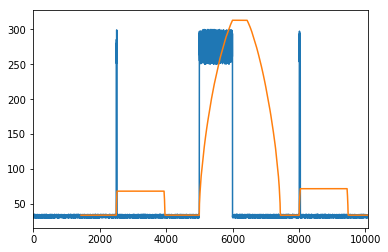

In [79]:
df = pd.DataFrame(temp_data)
df['std'] = df[0].rolling(1440).std()
df['mean'] = df[0].rolling(1440).mean()
df['fire temp'] = df['mean'] + df['std']

df[0].plot()
df['fire temp'].plot()

In [70]:
df['fire'] = np.where(df[0] > df.rolling(1440).mean() + df['std'], "yes", "no")


KeyboardInterrupt



In [2]:
class IOT_Data_Stream():
    
    pass

class Temperature_Stream(IOT_Data_Stream):
    
    pass

class Mega_Aggregator():
    
    def __init__(self):
        # sub-class of IOT_Data_Stream : df
        self.dict_of_IDS = {}
    
class Fire(Mega_Aggregator):
    
    def __init__(self):
        # temperature
        # humidity
        pass
    
    def model_signals():
        pass
    

In [4]:
class IOT_Device():
    
    #Object to represent an IOT device
    def __init__(self, df = None):
        self.df = df
        
    def add_entry(self, column_name, time, value):
        self.df.append(pd.Series({column_name: value}, name = time))

TypeError: 'module' object is not callable

In [6]:
import investpy

a = investpy.stocks.get_stock_historical_data('AAPL', 'united states', '01/01/2020', '01/05/2020')

In [15]:
import pandas as pd
b = pd.DataFrame(a['Close'])

In [19]:
b.append(pd.Series({'Close': 20}, name = 'allah'))

,Close
Date,
2020-01-02 00:00:00,300.35
2020-01-03 00:00:00,297.43
2020-01-06 00:00:00,299.80
2020-01-07 00:00:00,298.39
2020-01-08 00:00:00,303.19
...,...
2020-04-28 00:00:00,278.58
2020-04-29 00:00:00,287.73
2020-04-30 00:00:00,293.80
